# Hypno: Evading the Catastrophic Forgetting Problem in Block I.I.D. Data with Sleep

**TLDR**: In this project we propose an algorithm that attempts to mitigate the issue of catastrophic forgetting when learning on data that cyclicly changes distributions.

**Introduction and Background**: Distributed machine learning settings aim to learn a task by crowdsourcing data, this aids in evading issues such as overfitting by providing the learning model more general data.
However, this data is not always reliable and may be subject to e.g. poisoning attacks, tail distribution data, and faults. In this project we focus on the issue of data that cyclicly changes distribution and
properties over time, which we refer to as *block i.i.d. data*, this could for example occur naturally in a computer vision task where day and night cycles alter the images that input data. REFERENCE_BLOCK_IID has shown
that this setting causes the issue of catastrophic forgetting where after cycling to a new block, the model quickly forgets how to perform the task learn on the previous block. We aim to mitigate this issue with
a technique based on REFERENCE_SLEEP where at each training step, simulated sleeping is performed based on the previous blocks, ensuring that the model is more likely to remember previous tasks.

*Note: For this work we focus on the federated learning setting, however, it can be directly directly ported to distrbuted learning*

**How Hypno Works**: The Hypno algorithm is an add-on to the server side algorithm which is performed in two steps. The first step is to calculate the running moments of the current gradient, that is we calculate $\mathbb{E}[g_i]$ as
$\mu_i = \frac{1}{n_i}(\mu_i (n_i - 1) + g_i \eta_i)$ and $\mathbb{E}[g_i^2]$ as $\nu_i = \frac{1}{n_i}(\mu_i (n_i - 1) + g_i^2 \eta_i)$, where $g_i$ is the current average gradient taken from the clients in the $i$th block, $\mu_i$
is the element-wise average of $g_i$ with respect to time, $n_i$ is the number of updates that have been performed for that block, $\eta_i$ is weighting value for the sleeping gradients, and $\nu_i$ is the second-order element-wise moment of $g_i$ with respect
to time. The second step is to sleep, where the current block's gradient is averaged with the sleeping gradients of the other blocks where sleeping gradients are calculated as $N\left(\mu_i, \sqrt{\nu_j - \mu_j^2}\right)$. This simulates sleep by
giving random activations of neurons in the of pattern previous block's joint tasks.

## The Code

For the code, we start by importing everything we need:

In [2]:
from typing import Callable, Tuple, NamedTuple, Iterable, Any, Optional, List
from functools import partial
import jax
from jax import Array
import jax.numpy as jnp
import jaxopt
import optax
from optax import Params, Updates, GradientTransformation
import einops
import numpy as np
from numpy.typing import NDArray
import datasets
import flax.linen as nn
from sklearn import metrics
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt

PyTree = Any  # For some type annotations

Then we have three main classes: the [client](#The-Client), the [data library](#Data-Library), and the [server](#The-Server). The novel code is left to the server.

## The Client

Our client is relatively simple, it performs a `maxiter` number of local updates of the model, at each step taking a single minibatch of samples from its data object.

In [3]:
class Client:
    def __init__(
        self,
        params: Params,
        opt: GradientTransformation,
        loss_fun: Callable[[Params, Array, Array], float],
        maxiter: int = 1
    ):
        self.solver = jaxopt.OptaxSolver(opt=opt, fun=loss_fun, maxiter=maxiter)
        self.state = self.solver.init_state(params)
        self.step = jax.jit(self.solver.update)
        self.data = None

    def update(self, global_params: Params) -> Tuple[Updates, NamedTuple]:
        params = global_params
        for e in range(self.solver.maxiter):
            X, Y = next(self.data)
            params, self.state = self.step(params=params, state=self.state, X=X, Y=Y)
        gradient = jaxopt.tree_util.tree_sub(global_params, params)
        del params
        return gradient, self.state

## Data Library

Our data library contains classes that make it simpler to deal with data within the federated learning setting. First, we define a function that allocates data to the clients accord to the
latent directlet allocation, additionally it only includes classes that assigned to a specified block. Next, we define a iterator class for clients to retrieve data from. Finally, we define
a class that handles a full dataset.

In [4]:
def block_lda(
    labels: Iterable[int],
    nclients: int,
    nclasses: int,
    rng: np.random.Generator,
    block: Iterable[int],
    alpha: float=1.0
) -> list[list[float]]:
    r"""
    Latent Dirichlet allocation defined in https://arxiv.org/abs/1909.06335
    default value from https://arxiv.org/abs/2002.06440
    Optional arguments:
    - alpha: the $\alpha$ parameter of the Dirichlet function,
    the distribution is more i.i.d. as $\alpha \to \infty$ and less i.i.d. as $\alpha \to 0$
    """
    distribution = [[] for _ in range(nclients)]
    proportions = rng.dirichlet(np.repeat(alpha, nclients), size=nclasses)
    not_block = list(set(range(nclasses)) - set(block))
    proportions[not_block] = 0
    for c in range(nclasses):
        if np.sum(proportions[c]) == 0:
            continue
        idx_c = np.where(labels == c)[0]
        rng.shuffle(idx_c)
        dists_c = np.split(idx_c, np.round(np.cumsum(proportions[c]) * len(idx_c)).astype(int)[:-1])
        distribution = [distribution[i] + d.tolist() for i, d in enumerate(dists_c)]
    return distribution


class DataIter:
    def __init__(self, X: NDArray, Y: NDArray, batch_size: int, classes: int, rng: np.random.Generator):
        self.X, self.Y = X, Y
        self.batch_size = len(Y) if batch_size is None else min(batch_size, len(Y))
        self.len = len(Y)
        self.classes = classes
        self.rng = rng

    def __iter__(self):
        """Return this as an iterator."""
        return self

    def __next__(self) -> Tuple[NDArray, NDArray]:
        """Get a random batch."""
        idx = self.rng.choice(self.len, self.batch_size, replace=False)
        return self.X[idx], self.Y[idx]

    def __len__(self) -> int:
        """Get the number of unique samples in this iterator"""
        return len(self.Y)


class Dataset:
    """Object that contains the full dataset, primarily to prevent the need for reloading for each client."""

    def __init__(self, ds: datasets.Dataset, seed: Optional[int] = None):
        """
        Construct the dataset.

        Arguments:
        - ds: a hugging face dataset
        - seed: seed for rng used
        """
        self.ds = ds
        self.classes = len(np.union1d(np.unique(ds['train']['Y']), np.unique(ds['test']['Y'])))
        self.seed = seed

    @property
    def input_init(self) -> NDArray:
        """Get some dummy inputs for initializing a model."""
        return np.zeros((32,) + self.ds['train'][0]['X'].shape, dtype='float32')

    @property
    def input_shape(self) -> Tuple[int]:
        """Get the shape of a single sample in the dataset"""
        return self.ds['train'][0]['X'].shape

    def get_iter(
        self,
        split: str|Iterable[str],
        batch_size: Optional[int] = None,
        idx: Optional[Iterable[int]] = None,
    ) -> DataIter:
        """
        Generate an iterator out of the dataset.

        Arguments:
        - split: the split to use, either "train" or "test"
        - batch_size: the batch size
        - idx: the indices to use
        """
        rng = np.random.default_rng(self.seed)
        X, Y = self.ds[split]['X'], self.ds[split]['Y']
        if idx is not None:
            X, Y = X[idx], Y[idx]
        return DataIter(X, Y, batch_size, self.classes, rng)

    def get_test_iter(
        self,
        batch_size: Optional[int] = None,
    ):
        """
        Get a generator that deterministically gets batches of samples from the test dataset.

        Parameters:
        - batch_size: the number of samples to be included in each batch
        """
        X, Y = self.ds['test']['X'], self.ds['test']['Y']
        length = len(Y)
        if batch_size is None:
            batch_size = length
        idx_from, idx_to = 0, batch_size
        while idx_to < length:
            yield X[idx_from:idx_to], Y[idx_from:idx_to]
            idx_from = idx_to
            idx_to = min(idx_to + batch_size, length)

    def fed_split(
        self,
        batch_sizes: Iterable[int],
        mapping: Callable[[dict[str, Iterable[Any]]], dict[str, Iterable[Any]]] = None,
    ) -> List[DataIter]:
        """
        Divide the dataset for federated learning.

        Arguments:
        - batch_sizes: the batch sizes for each client
        - mapping: a function that takes the dataset information and returns the indices for each client
        - in_memory: Whether of not the data should remain in the memory
        """
        rng = np.random.default_rng(self.seed)
        if mapping is not None:
            distribution = mapping(self.ds['train']['Y'], len(batch_sizes), self.classes, rng)
            return [
                self.get_iter("train", b, idx=d)
                for b, d in zip(batch_sizes, distribution)
            ]
        return [self.get_iter("train", b) for b in batch_sizes]

## The Server

For the server, we first define a state class, which records the average loss, $\mu$, $\nu$, and $n$, this is to replicate the step functionality of the jaxopt optimizers.

In [5]:
class State(NamedTuple):
    """A simple global state class"""
    value: float
    """The result of the function being learned"""
    mew: list
    new: list
    times_updated: list[int]

Then we define the server, which when constructed stores the parameters and some data/block counting variables. Our main novel code is in the update method, which first finds the average client gradient
then updates $\mu_i$, $\nu_i$, and $n_i$, and finally if the block has changed at least once, the average client gradient is averaged with the sleeping gradient.

In [33]:
class Server:
    def __init__(
        self,
        model: nn.Module,
        params: Params,
        clients: Iterable[Client],
        maxiter: int = 5,
        sleep_weighting: float = 2.0,
        total_blocks: int = 2,
        seed: Optional[int] = None,
        use_hypno: bool = True
    ):
        self.model = model
        self.params = params
        self.clients = clients
        self.maxiter = maxiter
        self.rng = np.random.default_rng(seed)
        self.block_sizes = np.array([0 for _ in range(total_blocks)])
        self.sleep_weighting = sleep_weighting
        self.current_block = -1
        self.total_blocks = total_blocks
        self.block_changes = -1
        self.use_hypno = use_hypno

    def init_state(self, params: Params) -> State:
        return State(
            np.inf,
            [jax.tree_map(jnp.zeros_like, self.params) for _ in range(self.total_blocks)],
            [jax.tree_map(jnp.zeros_like, self.params) for _ in range(self.total_blocks)],
            times_updated = [1 for _ in range(self.total_blocks)]
        )

    def update(self, params: Params, server_state: State) -> Tuple[Params, State]:
        all_grads, all_states = [], []
        for c in self.clients:
            grads, state = c.update(params)
            all_grads.append(grads)
            all_states.append(state)
        meaned_grads = tree_mean(*all_grads)
        grad_mew, grad_new, times_updated = server_state.mew, server_state.new, server_state.times_updated
        if self.use_hypno:
            grad_mew[self.current_block] = update_mew(
                server_state.mew[self.current_block],
                meaned_grads,
                times_updated[self.current_block],
                self.sleep_weighting
            )
            grad_new[self.current_block] = update_new(
                server_state.new[self.current_block],
                meaned_grads,
                times_updated[self.current_block],
                self.sleep_weighting
            )
            times_updated[self.current_block] += 1
            if self.block_changes:
                meaned_grads = self.sleep(meaned_grads, server_state)
        params = tree_add_scalar_mul(params, -1, meaned_grads)
        return params, State(np.mean([s.value for s in all_states]), grad_mew, grad_new, times_updated)

    def sleep(self, meaned_grads, server_state):
        z_grads = []
        for i, (mew, new) in enumerate(zip(server_state.mew, server_state.new)):
            if i != self.current_block and i <= self.block_changes:
                grads = jax.tree_map(lambda m, n: self.rng.normal(m, jnp.sqrt(n - m**2)), mew, new)
                z_grads.append(grads)
        return tree_average(meaned_grads, *z_grads, weightings=self.block_sizes / self.block_sizes.sum())

    def change_block(self, data):
        block_size = 0
        for c, d in zip(self.clients, data):
            c.data = d
            block_size += len(d)
        self.current_block = (self.current_block + 1) % self.total_blocks
        self.block_sizes[self.current_block] = block_size
        self.block_changes += 1

The following are auxillary functions for the server. The first two update $\mu$ and $\nu$, the next two perform average and weighted average of input gradients, and the last adds a scalar multiple of an input gradient to the input parameters.

In [8]:
def update_mew(grad_mew, new_grads, times_updated, sleep_weighting):
    return jax.tree_map(lambda m, g: ((m * (times_updated - 1)) + (g * sleep_weighting)) / times_updated, grad_mew, new_grads)


def update_new(grad_new, new_grads, times_updated, sleep_weighting):
    return jax.tree_map(lambda m, g: ((m * (times_updated - 1)) + (g * sleep_weighting)**2) / times_updated, grad_new, new_grads)


@jax.jit
def tree_mean(*trees: Params) -> Params:
    """Average together a collection of pytrees"""
    return jax.tree_util.tree_map(lambda *ts: sum(ts) / len(trees), *trees)


@jax.jit
def tree_average(*trees: Params, weightings: Array) -> Params:
    """Average together a collection of pytrees"""
    return jax.tree_util.tree_map(lambda *ts: sum([t * w for t, w in zip(ts, weightings)]) / len(trees), *trees)


@jax.jit
def tree_add_scalar_mul(tree_a: Params, mul: float, tree_b: Params) -> Params:
    """Add a scaler multiple of tree_b to tree_a"""
    return jax.tree_util.tree_map(lambda a, b: a + mul * b, tree_a, tree_b)

## Experiments

Now for the experiments.

First we define the LeNet-300-100 model:

In [9]:
class LeNet(nn.Module):
    @nn.compact
    def __call__(self, x: Array, representation: bool = False) -> Array:
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        x = nn.Dense(300)(x)
        x = nn.relu(x)
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        if representation:
            return x
        x = nn.Dense(10, name="classifier")(x)
        return nn.softmax(x)

Then the cross-entropy loss:

In [10]:
def celoss(model: nn.Module) -> Callable[[PyTree, Array, Array], float]:
    """
    A cross-entropy loss function

    Arguments:
    - model: Model function that performs predictions given parameters and samples
    """
    @jax.jit
    def _apply(params: PyTree, X: Array, Y: Array) -> float:
        logits = jnp.clip(model.apply(params, X), 1e-15, 1 - 1e-15)
        one_hot = jax.nn.one_hot(Y, logits.shape[-1])
        return -jnp.mean(jnp.einsum("bl,bl -> b", one_hot, jnp.log(logits)))
    return _apply

Then an efficient metric recording function, and accuracy and confusion metric functions that call it:

In [11]:
def take_metric(
    model: nn.Module,
    variables: PyTree,
    ds: Iterable[Tuple[Array|Tuple[Array, Array], Array]],
    metric_fn
):
    """
    Calculate the accuracy of the model across the given dataset

    Arguments:
    - model: Model function that performs predictions given parameters and samples
    - variables: Parameters and other learned values used by the model
    - ds: Iterable data over which the accuracy is calculated
    """
    @jax.jit
    def _apply(batch_X: Array|Tuple[Array, Array]) -> Array:
        return jnp.argmax(model.apply(variables, batch_X), axis=-1)
    preds, Ys = [], []
    for X, Y in ds:
        preds.append(_apply(X))
        Ys.append(Y)
    return metric_fn(jnp.concatenate(Ys), jnp.concatenate(preds))


def accuracy(model, variables, ds):
    return take_metric(model, variables, ds, metrics.accuracy_score)


def confusion_matrix(model, variables, ds):
    return take_metric(model, variables, ds, metrics.confusion_matrix)

And for the final auxillary function, we load and preprocess the MNIST (or other) dataset from the [hugging face](huggingface.co) repository. Our preprocessing simply involves dividing the pixel values into the range $\mathbb{R} \cap [0, 1]$.

In [15]:
def load_dataset(seed: int, ds_name="mnist"):
    """
    Load the MNIST dataset

    Arguments:
    - seed: seed value for the rng used in the dataset
    - ds_name: name of the dataset to be loaded
    """
    ds = datasets.load_dataset(ds_name)
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return Dataset(ds, seed)

Our final function creates the experiment with several arguements that are defined in the documenting comment. This function creates all required classes and trains through each block cyclically.

In [39]:
def experiment(num_clients=10, seed=42, blocks=2, cycles=2, epochs=1, rounds=500, batch_size=32, use_hypno=True, client_opt=optax.sgd(0.1), ds_name="mnist"):
    """
    Evaluate the effects of hypno against catastrophic forgetting.
    
    Arguments:
    - num_clients: Number of clients for the simulation
    - seed: Seed for the simulation
    - blocks: Number of blocks for the simulation
    - cycles: Number of cycles for the simulation
    - epochs: Epochs of local training to be performed in each round
    - rounds: Rounds per block for the simulation
    - batch_size: Minibatch size for the simulation
    - use_hypno: Whether to apply the Hypno algorithm
    - client_opt: Optimizer to be used by clients
    - ds_name: Name of the dataset to load
    """
    sns.set_theme()

    dataset = load_dataset(seed, ds_name=ds_name)
    blocks = np.split(np.arange(dataset.classes), blocks)
    model = LeNet()
    params = model.init(jax.random.PRNGKey(seed), dataset.input_init)
    clients = [Client(params, client_opt, celoss(model), maxiter=epochs) for _ in range(num_clients)]
    server = Server(model, params, clients, maxiter=rounds, total_blocks=len(blocks), seed=seed, use_hypno=use_hypno)
    state = server.init_state(params)

    for c in range(cycles):
        for block in blocks:
            data = dataset.fed_split(
                [batch_size for _ in range(num_clients)],
                partial(block_lda, block=block, alpha=1.0)
            )
            server.change_block(data)
            for _ in (pbar := trange(server.maxiter)):
                params, state = server.update(params, state)
                pbar.set_postfix_str(f"LOSS: {state.value:.3f}")

            test_data = dataset.get_test_iter(batch_size)
            sns.heatmap(confusion_matrix(model, params, test_data), fmt='d', annot=True, cbar=False)
            plt.show()

## Results

Here we demonstrate some calls of the experiment function, showing results, we see that our Hypno algorithm experiences some success but is not perfect.

First a baseline demonstration of the catastrophic forgetting effect with canonical federated learning:

Found cached dataset mnist (/home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-6674e9dd4a9ecccf.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-c4949c1c2fa9cdb0.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-fcb8604b588eba78.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-564128758dfbbf89.arrow


  0%|          | 0/500 [00:00<?, ?it/s]

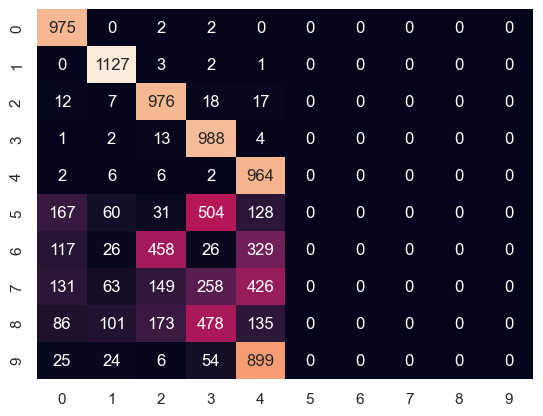

  0%|          | 0/500 [00:00<?, ?it/s]

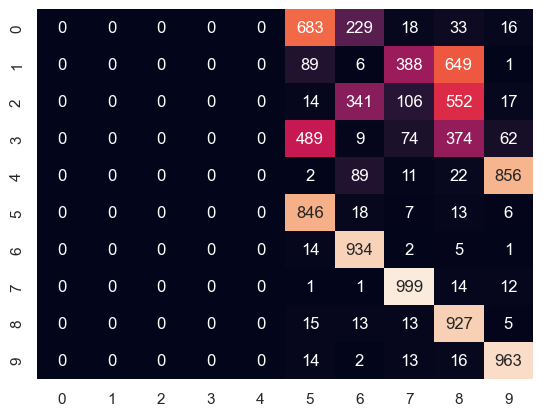

  0%|          | 0/500 [00:00<?, ?it/s]

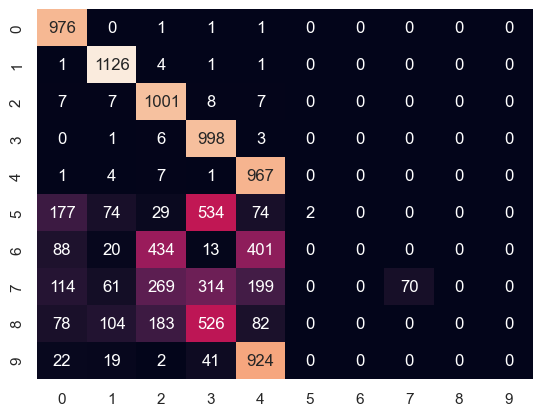

  0%|          | 0/500 [00:00<?, ?it/s]

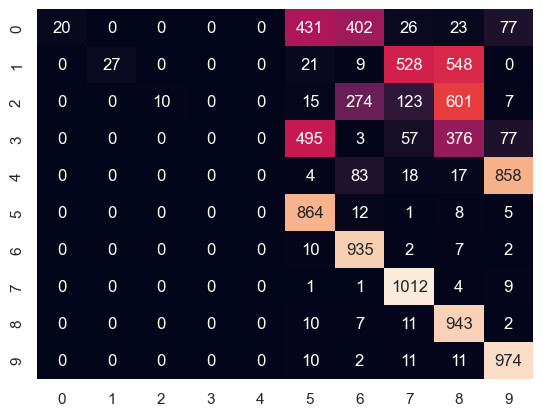

In [34]:
experiment(use_hypno=False)

We see that since each block either contains either the first five or last five classes, during training of each block, the model only remembers how to accurately
predict samples from the classes in the current block.

Now compare to our proposed Hypno algorithm:

Found cached dataset mnist (/home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-6674e9dd4a9ecccf.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-c4949c1c2fa9cdb0.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-fcb8604b588eba78.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-564128758dfbbf89.arrow


  0%|          | 0/500 [00:00<?, ?it/s]

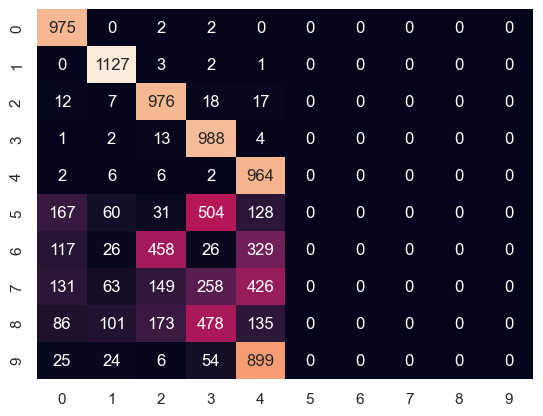

  0%|          | 0/500 [00:00<?, ?it/s]

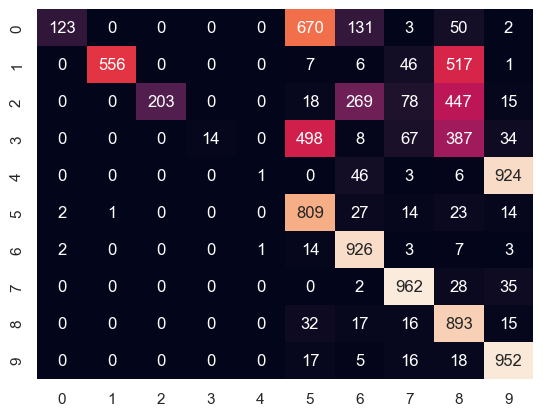

  0%|          | 0/500 [00:00<?, ?it/s]

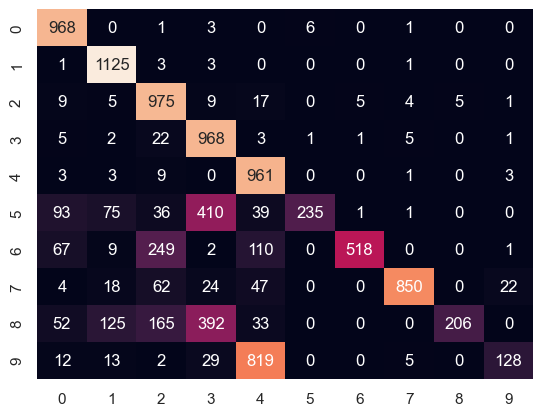

  0%|          | 0/500 [00:00<?, ?it/s]

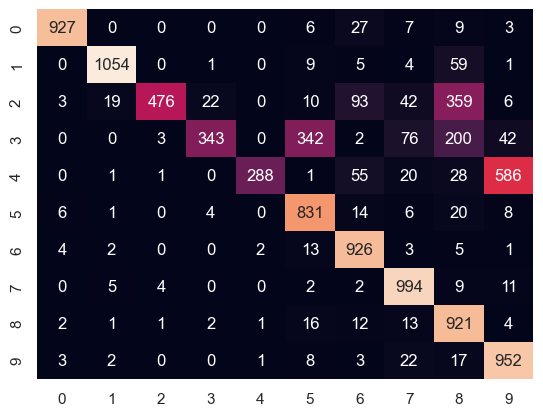

In [35]:
experiment()

After the first cycle, Hypno training learns a model that for the most part accurately predicts all classes regardless of which block they belong to.

### For Smaller Number of Rounds Momentum is Better

The following experiments show how when there is a smaller number of rounds per block, simply having the clients train with a SGD with momentum optimizer is sufficient to mitigate catastrophic forgetting. We show over 10 cycles of 5 round blocks.

First the baseline:

Found cached dataset mnist (/home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-6674e9dd4a9ecccf.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-c4949c1c2fa9cdb0.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-fcb8604b588eba78.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-564128758dfbbf89.arrow


  0%|          | 0/5 [00:00<?, ?it/s]

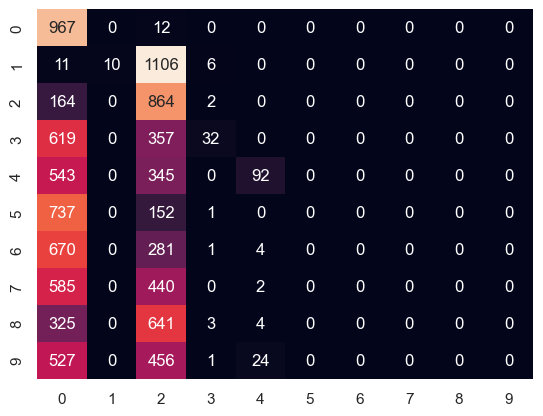

  0%|          | 0/5 [00:00<?, ?it/s]

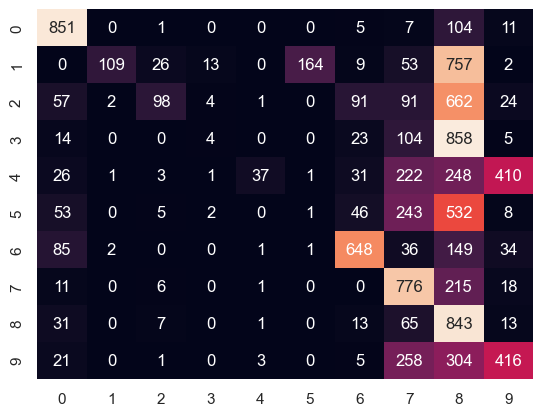

  0%|          | 0/5 [00:00<?, ?it/s]

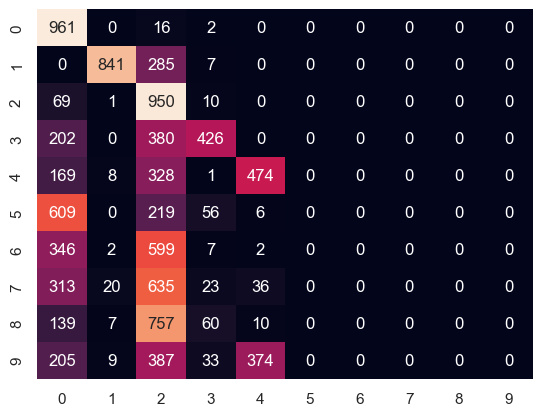

  0%|          | 0/5 [00:00<?, ?it/s]

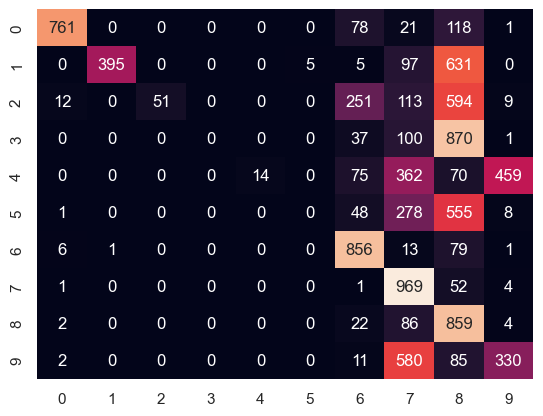

  0%|          | 0/5 [00:00<?, ?it/s]

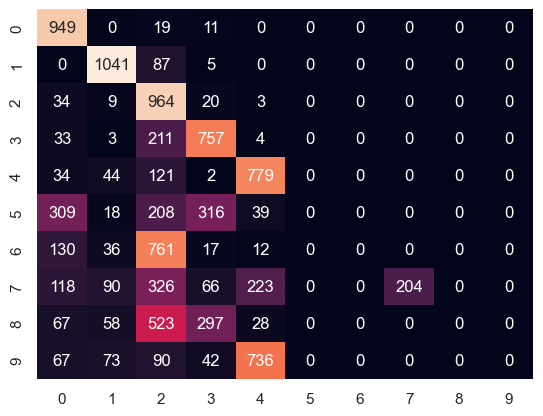

  0%|          | 0/5 [00:00<?, ?it/s]

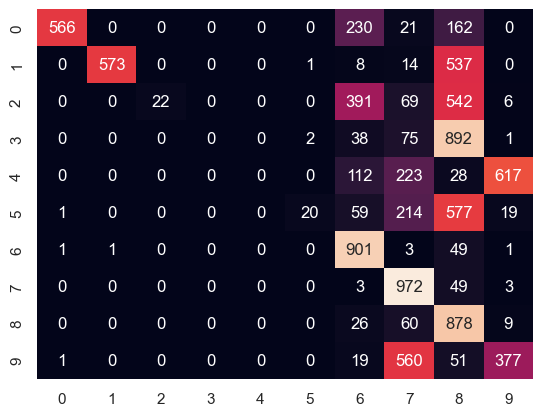

  0%|          | 0/5 [00:00<?, ?it/s]

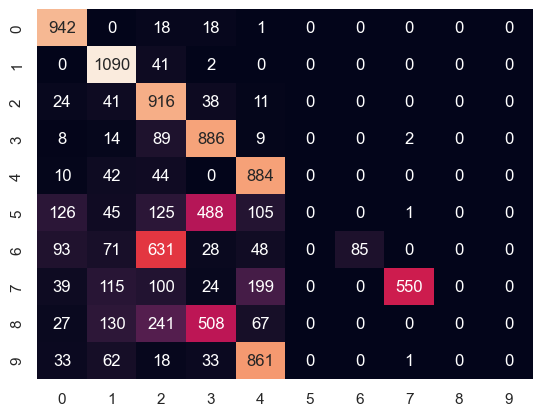

  0%|          | 0/5 [00:00<?, ?it/s]

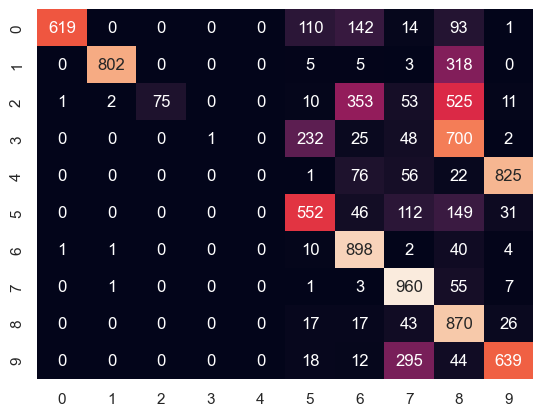

  0%|          | 0/5 [00:00<?, ?it/s]

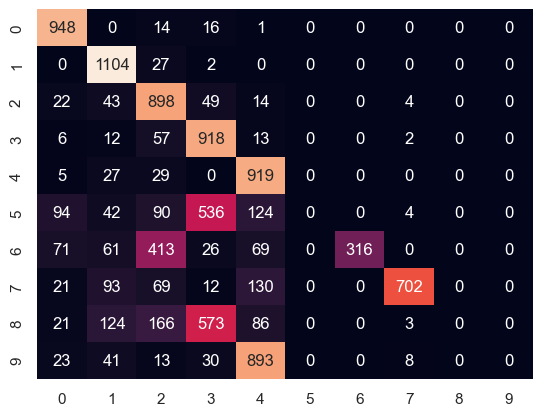

  0%|          | 0/5 [00:00<?, ?it/s]

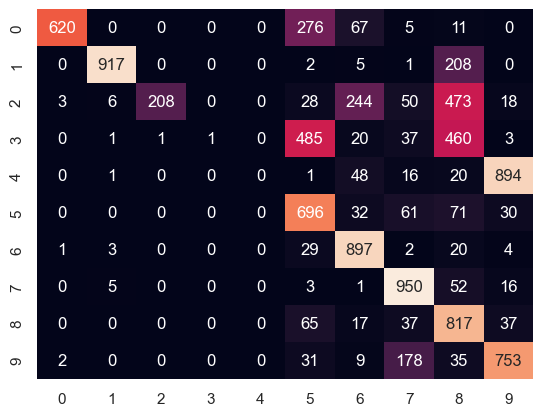

  0%|          | 0/5 [00:00<?, ?it/s]

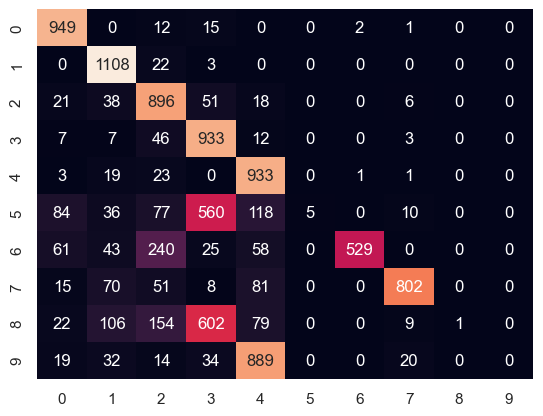

  0%|          | 0/5 [00:00<?, ?it/s]

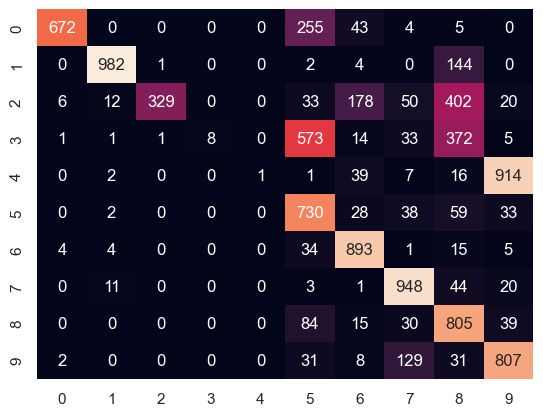

  0%|          | 0/5 [00:00<?, ?it/s]

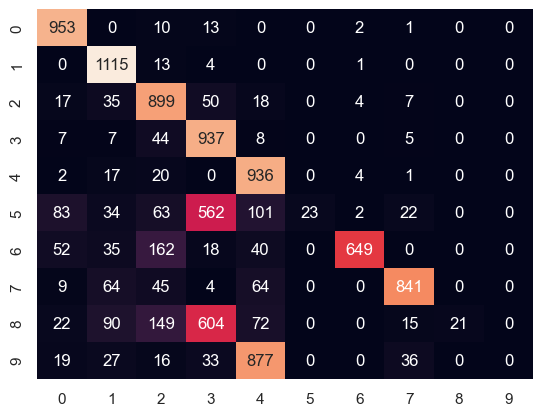

  0%|          | 0/5 [00:00<?, ?it/s]

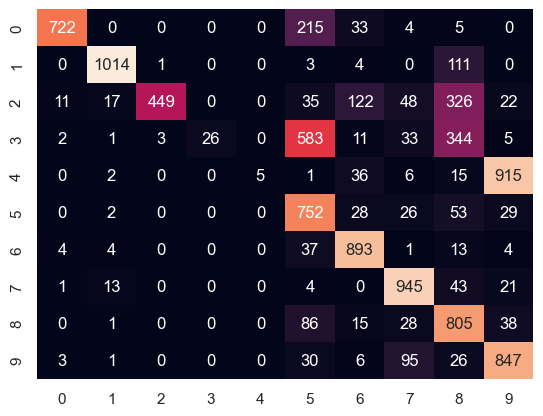

  0%|          | 0/5 [00:00<?, ?it/s]

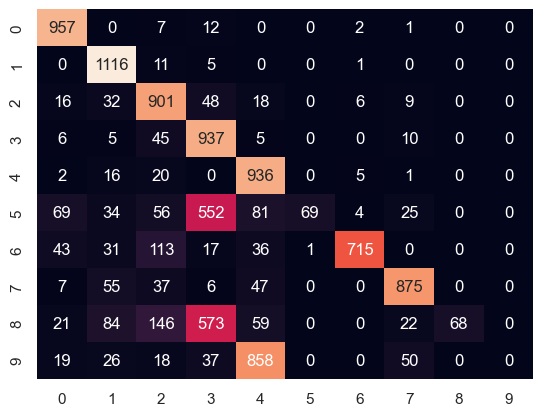

  0%|          | 0/5 [00:00<?, ?it/s]

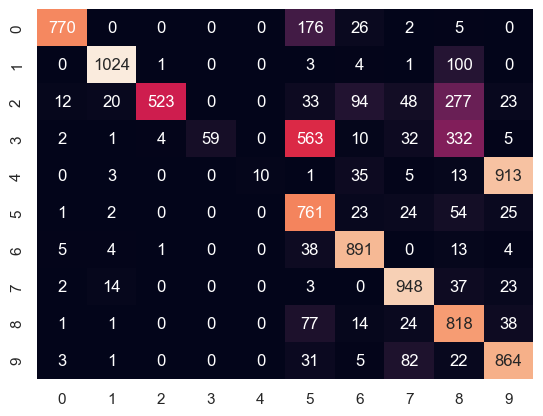

  0%|          | 0/5 [00:00<?, ?it/s]

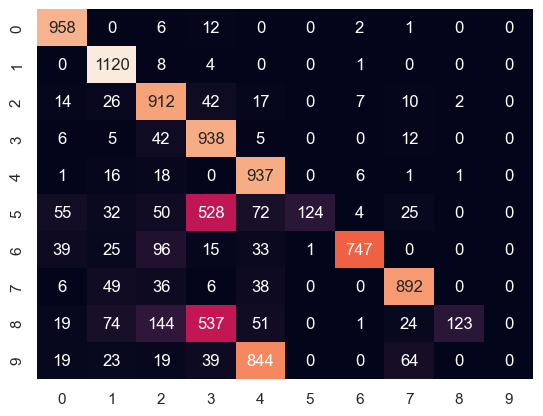

  0%|          | 0/5 [00:00<?, ?it/s]

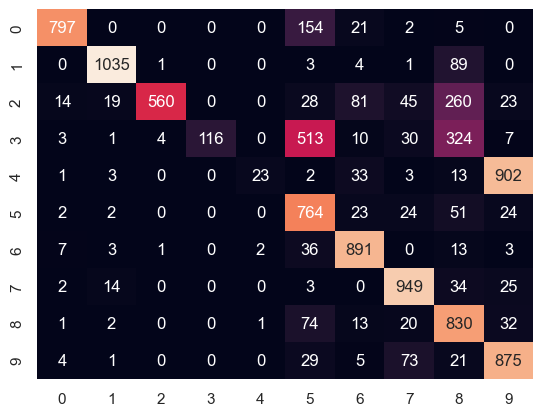

  0%|          | 0/5 [00:00<?, ?it/s]

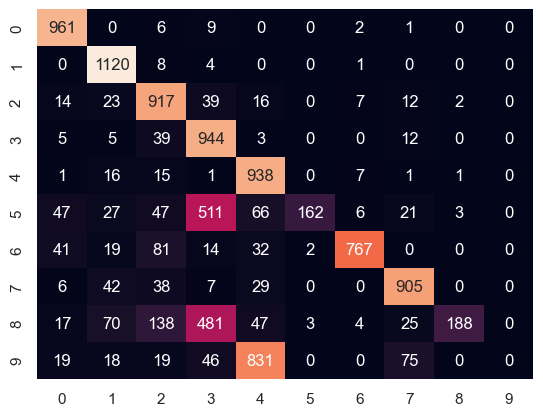

  0%|          | 0/5 [00:00<?, ?it/s]

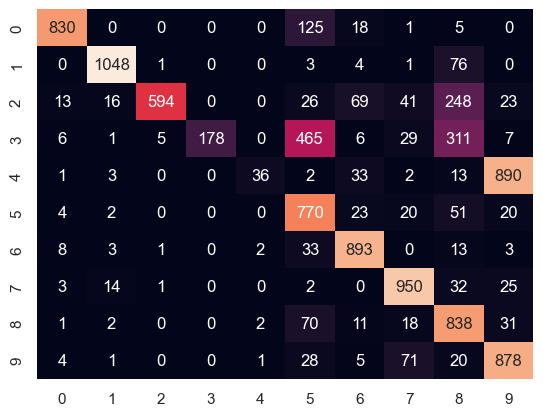

In [36]:
experiment(use_hypno=False, rounds=5, cycles=10)

Due the small number of rounds, the baseline performs reasonably well, however, better results are possible.

Next Hypno:

Found cached dataset mnist (/home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-6674e9dd4a9ecccf.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-c4949c1c2fa9cdb0.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-fcb8604b588eba78.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-564128758dfbbf89.arrow


  0%|          | 0/5 [00:00<?, ?it/s]

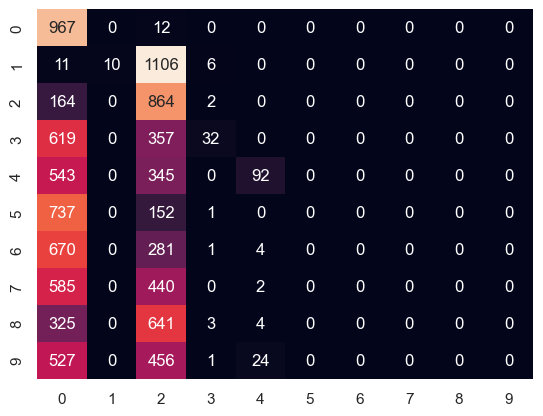

  0%|          | 0/5 [00:00<?, ?it/s]

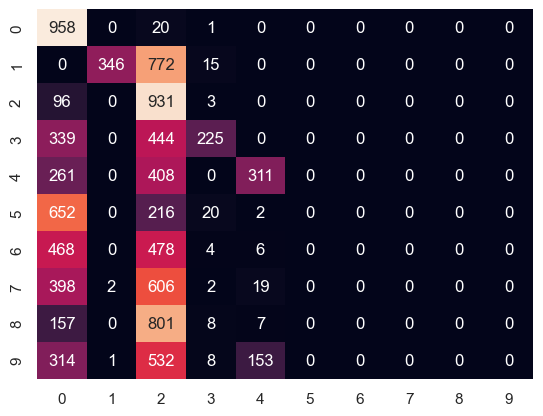

  0%|          | 0/5 [00:00<?, ?it/s]

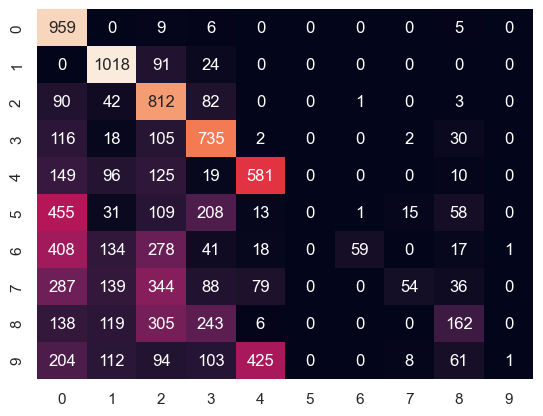

  0%|          | 0/5 [00:00<?, ?it/s]

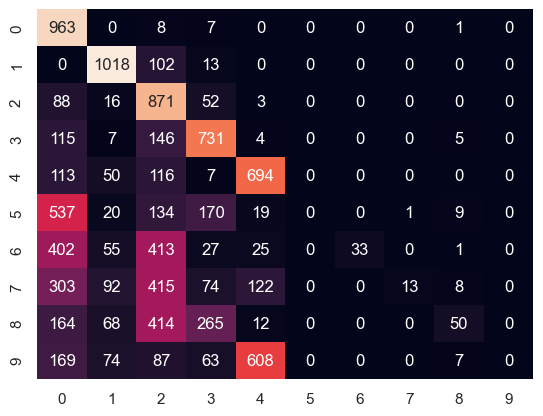

  0%|          | 0/5 [00:00<?, ?it/s]

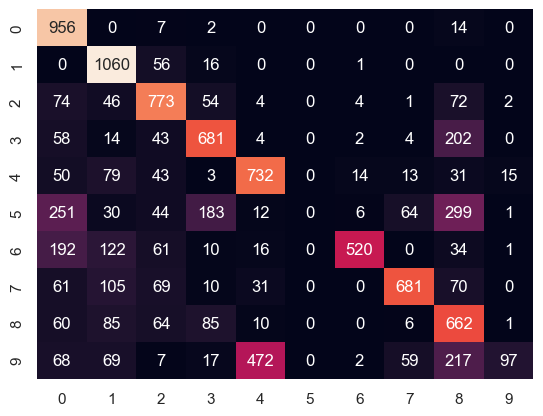

  0%|          | 0/5 [00:00<?, ?it/s]

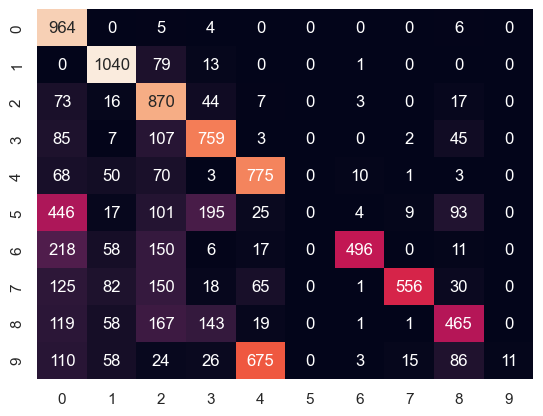

  0%|          | 0/5 [00:00<?, ?it/s]

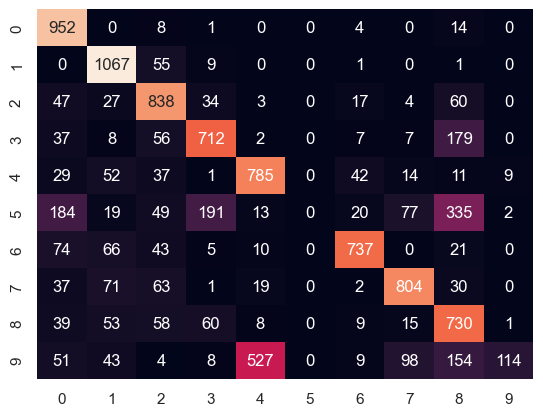

  0%|          | 0/5 [00:00<?, ?it/s]

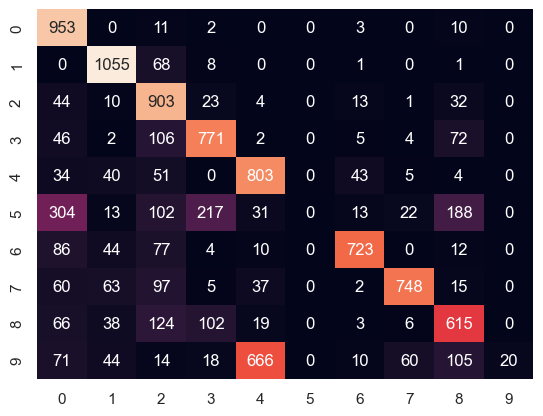

  0%|          | 0/5 [00:00<?, ?it/s]

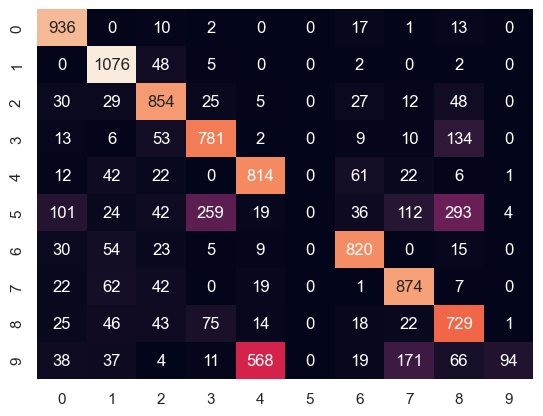

  0%|          | 0/5 [00:00<?, ?it/s]

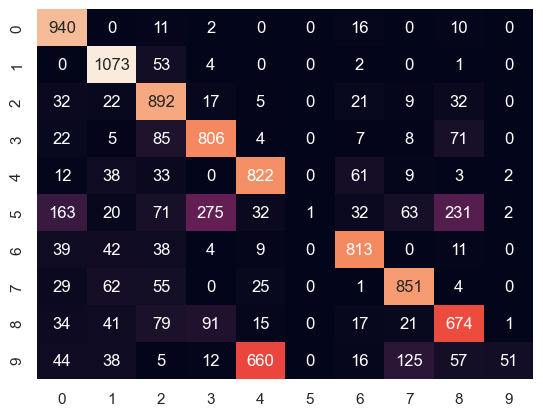

  0%|          | 0/5 [00:00<?, ?it/s]

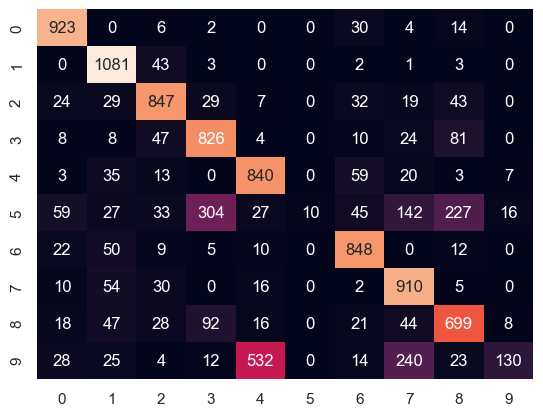

  0%|          | 0/5 [00:00<?, ?it/s]

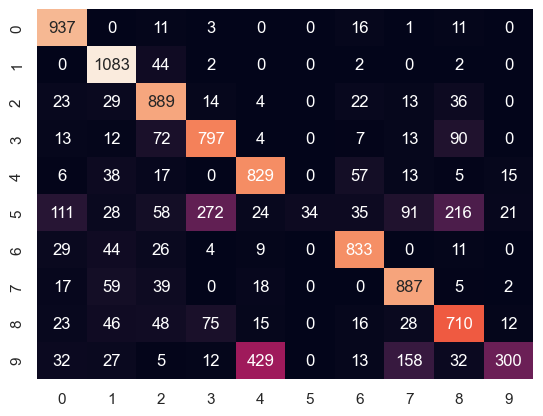

  0%|          | 0/5 [00:00<?, ?it/s]

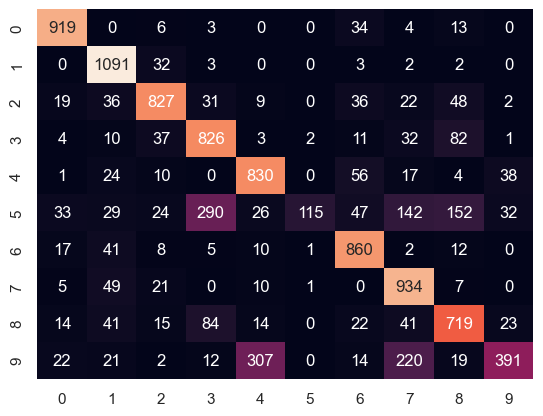

  0%|          | 0/5 [00:00<?, ?it/s]

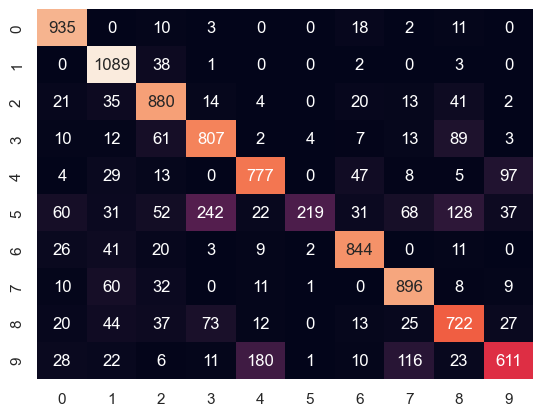

  0%|          | 0/5 [00:00<?, ?it/s]

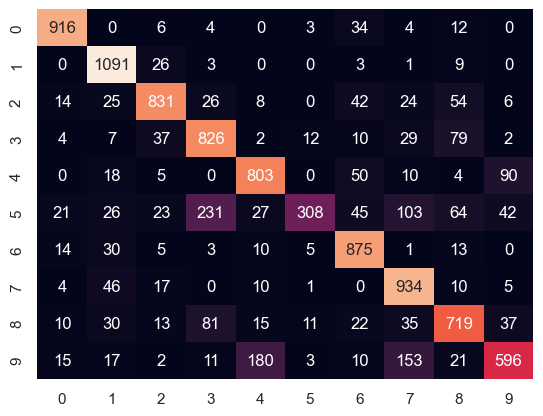

  0%|          | 0/5 [00:00<?, ?it/s]

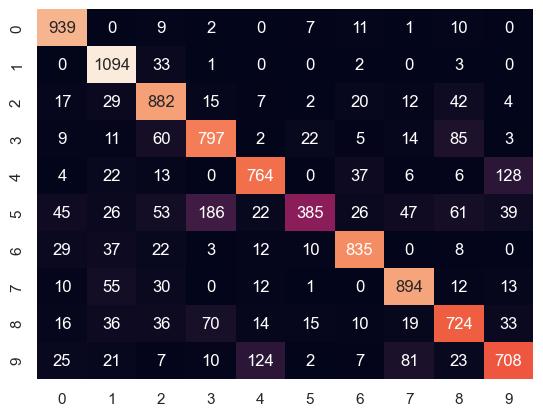

  0%|          | 0/5 [00:00<?, ?it/s]

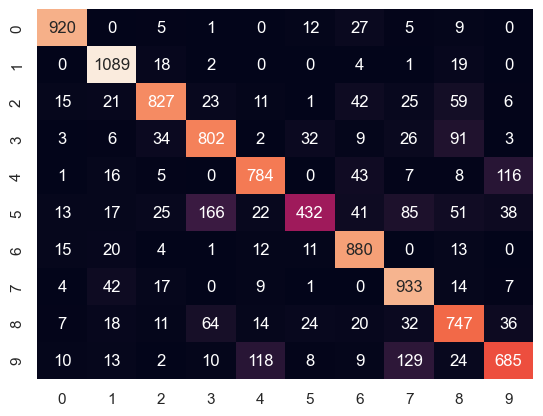

  0%|          | 0/5 [00:00<?, ?it/s]

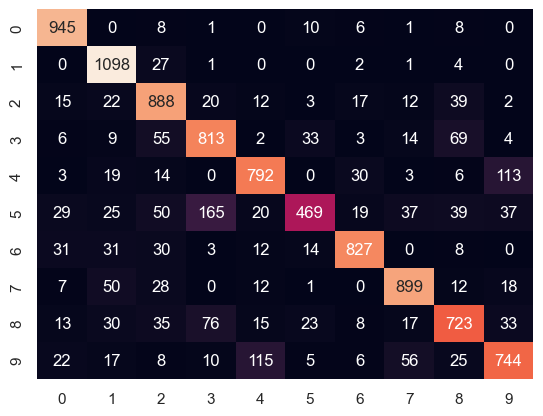

  0%|          | 0/5 [00:00<?, ?it/s]

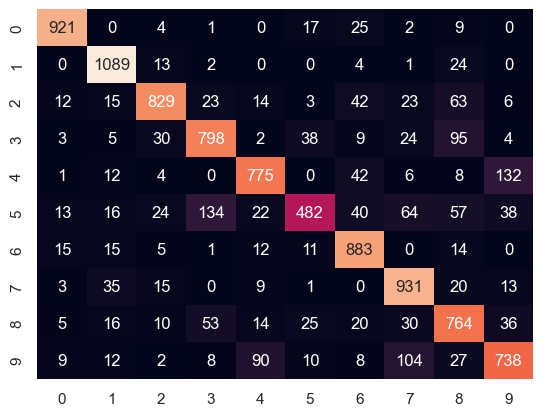

  0%|          | 0/5 [00:00<?, ?it/s]

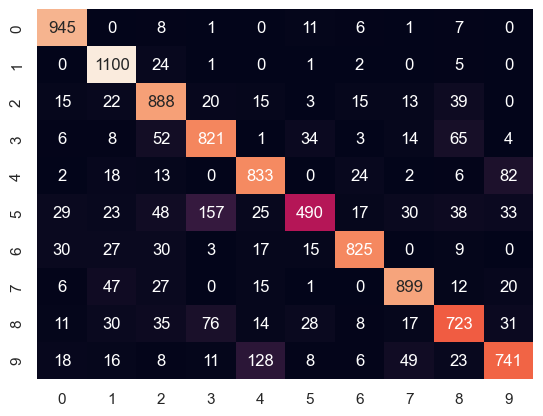

In [37]:
experiment(rounds=5, cycles=10)

Hypno improves upon the baseline, yet we will see that momentum can achieve similar improvements without server intervention.

And finally momentum:

Found cached dataset mnist (/home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-6674e9dd4a9ecccf.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-c4949c1c2fa9cdb0.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-fcb8604b588eba78.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4/cache-564128758dfbbf89.arrow


  0%|          | 0/5 [00:00<?, ?it/s]

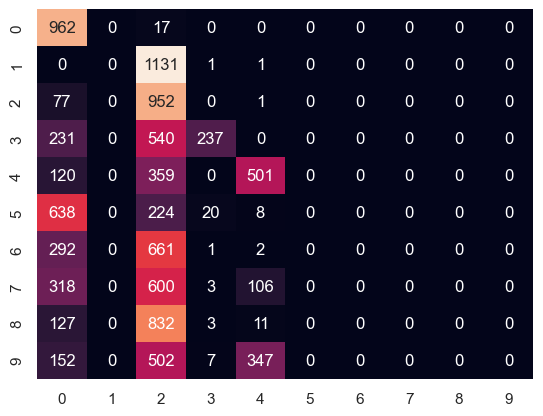

  0%|          | 0/5 [00:00<?, ?it/s]

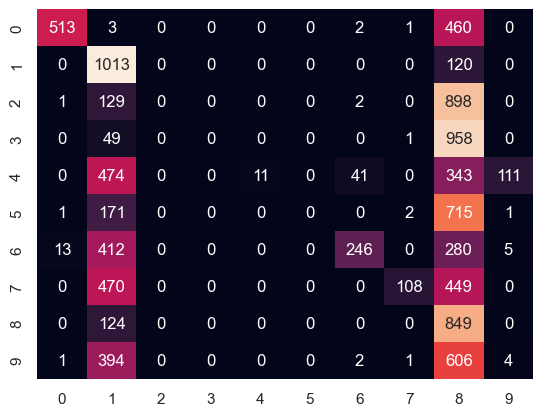

  0%|          | 0/5 [00:00<?, ?it/s]

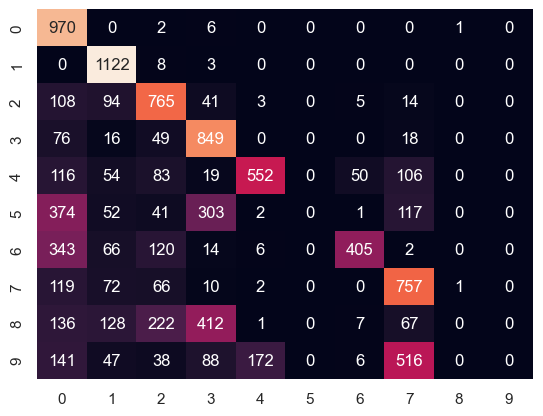

  0%|          | 0/5 [00:00<?, ?it/s]

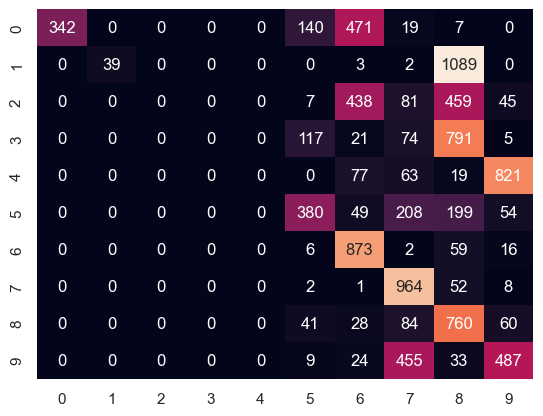

  0%|          | 0/5 [00:00<?, ?it/s]

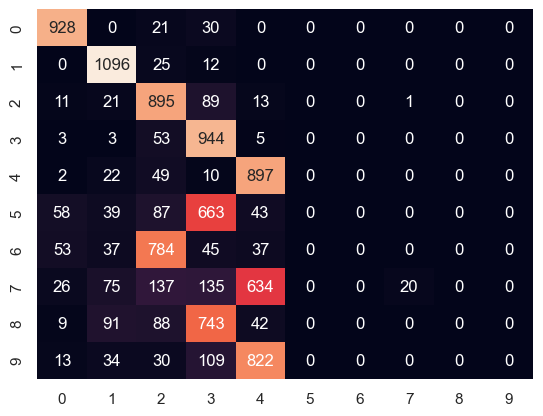

  0%|          | 0/5 [00:00<?, ?it/s]

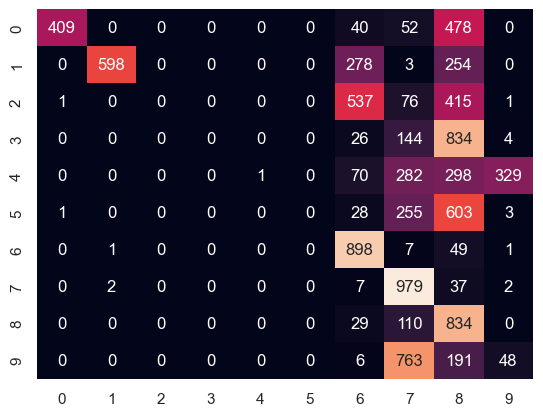

  0%|          | 0/5 [00:00<?, ?it/s]

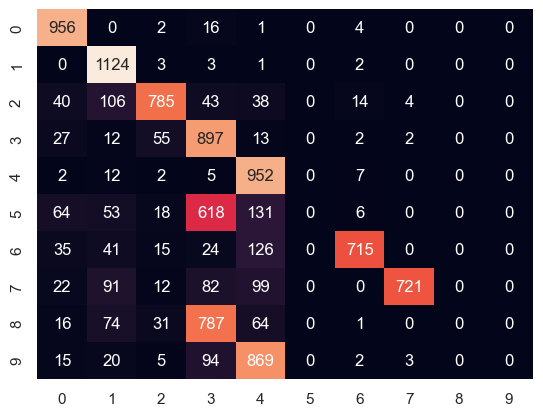

  0%|          | 0/5 [00:00<?, ?it/s]

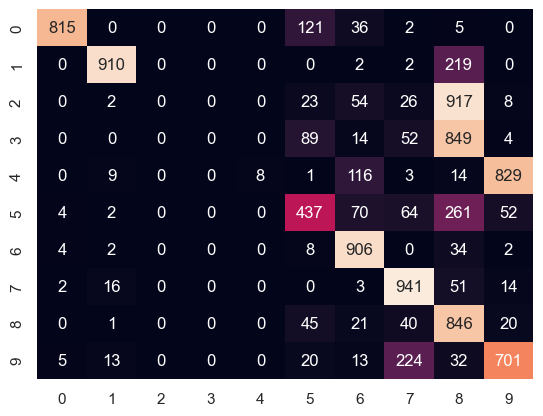

  0%|          | 0/5 [00:00<?, ?it/s]

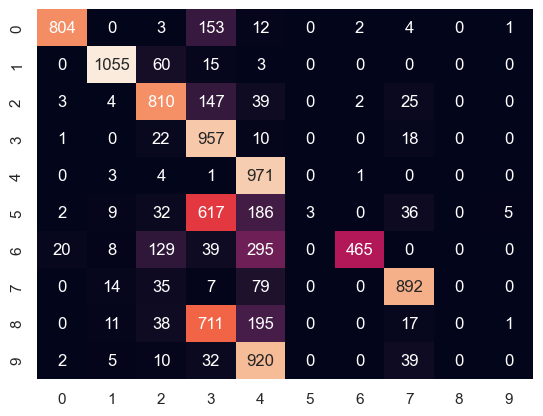

  0%|          | 0/5 [00:00<?, ?it/s]

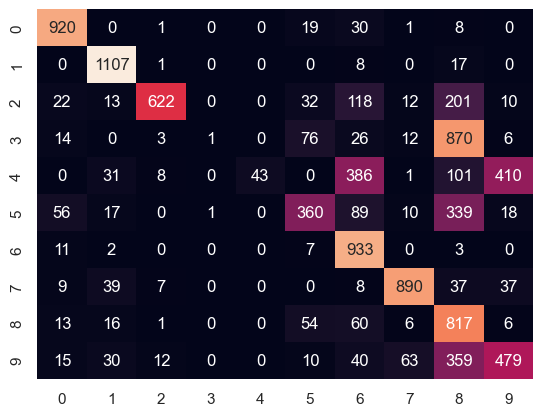

  0%|          | 0/5 [00:00<?, ?it/s]

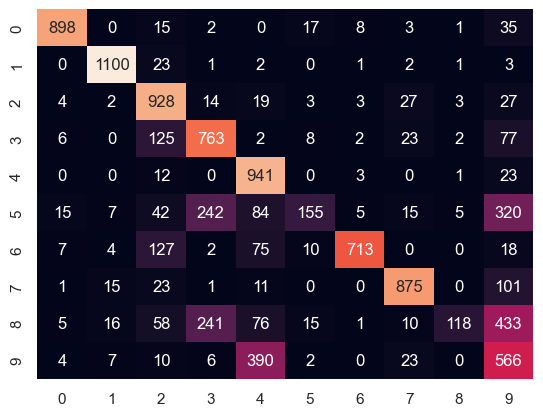

  0%|          | 0/5 [00:00<?, ?it/s]

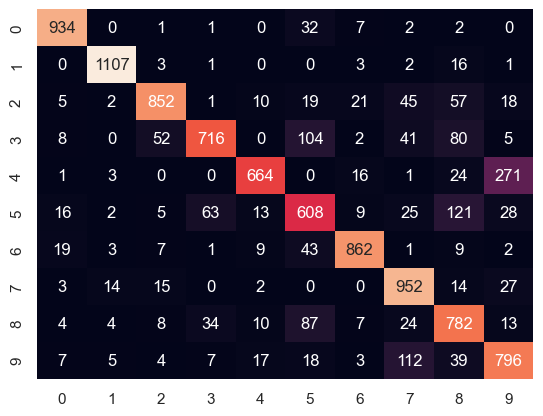

  0%|          | 0/5 [00:00<?, ?it/s]

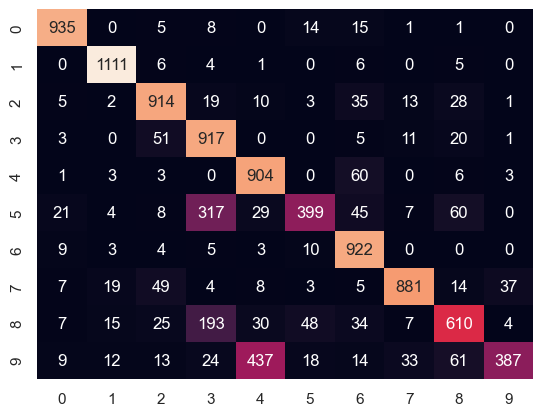

  0%|          | 0/5 [00:00<?, ?it/s]

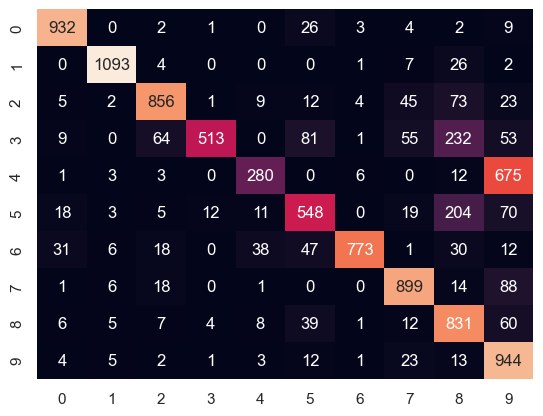

  0%|          | 0/5 [00:00<?, ?it/s]

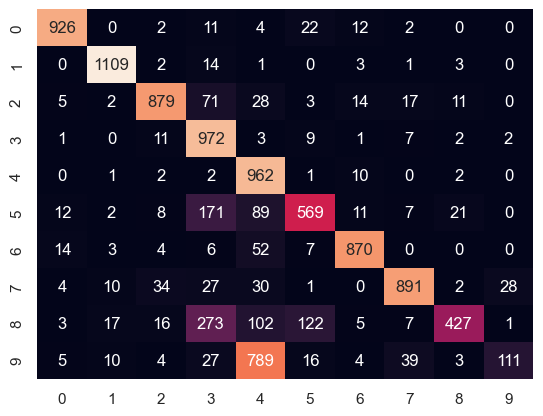

  0%|          | 0/5 [00:00<?, ?it/s]

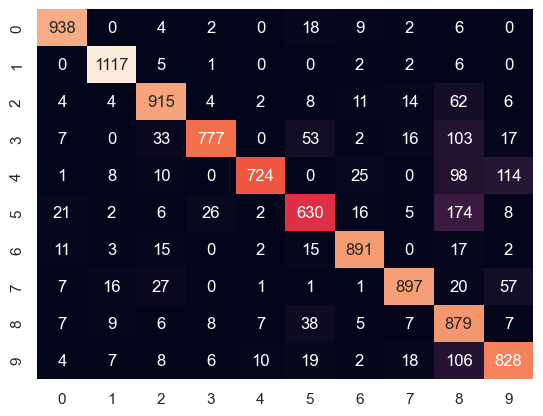

  0%|          | 0/5 [00:00<?, ?it/s]

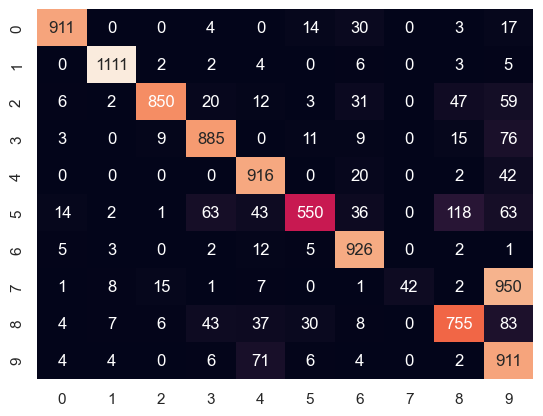

  0%|          | 0/5 [00:00<?, ?it/s]

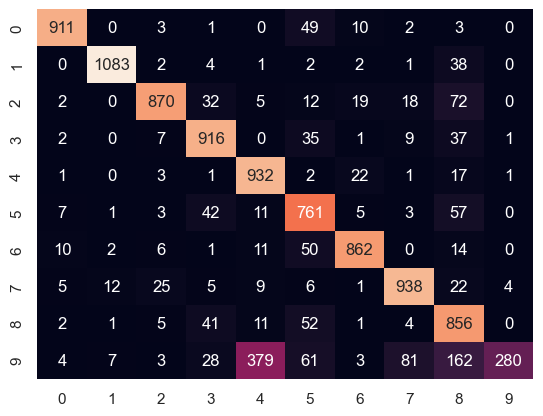

  0%|          | 0/5 [00:00<?, ?it/s]

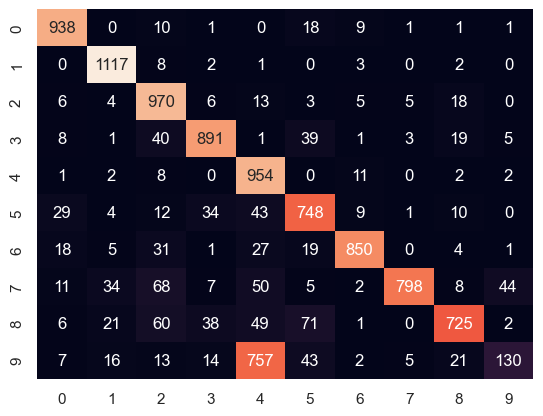

  0%|          | 0/5 [00:00<?, ?it/s]

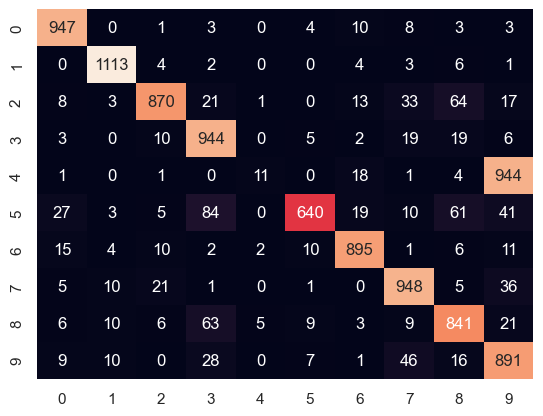

In [40]:
experiment(use_hypno=False, rounds=5, cy:cles=10, client_opt=optax.sgd(0.1, momentum=0.9))

While slightly blemished at the final block, we see that that, in general, simply using client side momentum achieves similar benefits as Hypno does.